# INFO 3350/6350

## Lecture 09: Clustering (and TF-IDF weighting)

## To do

* Reading for Weds: Allison et al., Mauch et al.
    * Response due by Tuesday at 4:00pm for those designated this week
* HW4 (distance metrics) due by Thursday night at 11:59.
* How to get help
    * Start early
    * Read the documentation
    * Join a study group
    * Read any error messages
        * Key info is often at the **bottom** of the error output
    * Explain your problem to someone else
    * Document what you've done
    * Post publicly on Ed
    * Come to office hours with specific questions
        * TAs will not write code for you; they will ask you what you're trying to do, what you've done, and what the problem is
        * TAs will give you things to consider

## Aside: TF-IDF weighting for word counts

* Why do we sometimes remove stopwords from our features?
    * High-frequency words shared by many documents don't tell us (in many, but not all, cases) much about the similarities or differences between documents
* But stopword lists are binary: a word is either a stopword (hence, removed) or it isn't
* Can we define a continuous adjustment for "stoppiness" that we apply to *every* word, depending on how widely used it is?
* One approach is "term frequency-inverse document frequency" (TFIDF) weighting. 
    * You can think of this as multiplying the count of each term in a document by the inverse of the fraction of all documents in which that word occurs (hence "term frequency [multiplied by] inverse document frequency"). It's a bit more complicated than that (see below), but that's the idea. This upweights words that occur in relatively few documents.
    * The count of a word that occurs in every document would be multiplied by one, hence get no boost in each document. A word that occurs in just one document in a corpus of 100 documents would be multiplied by 100 in the one document that contains it.
* There are several tweaks to TFIDF to smooth it out and to modulate the boost it provides. `scikit-learn`'s `TfidfVectorizer` applies the reweighting:

$$idf(t) = \ln\frac{1+n}{1 + df(t)} + 1$$

Where:

* $t$ is the term in question
* $idf(t)$ is the inverse document weight to be applied to the count of term $t$
* $n$ is the number of documents in the corpus
* $df(t)$ is the number of documents in the corpus that contain term $t$

A toy example: Consider two documents:

* Document 1: `"cat dog"`
* Document 2: `"dog dog"`

`cat` occurs in just one document; `dog` occurs in both documents. So we want (and expect) to upweight the count of `cat` in document 1.

Calculate the `idf` weight for `cat` in document 1:

* $n = 2$
* $df(\text{'cat'}) = 1$

$$idf(\text{'cat'}) = \ln\frac{1 + 2}{1 + 1} + 1 = \ln\frac{3}{2} + 1 = 1.405$$

And for `dog` in document 1:

* $n = 2$
* $df(\text{'dog'}) = 2$

$$idf(\text{'dog'}) = \ln\frac{1 + 2}{1 + 2} + 1 = \ln\frac{3}{3} + 1 = 1.0$$

So, `cat` will be upweighted relative to `dog`, because it is the less widely used word across documents in the corpus.

Our non-normalized but IDF-weighted feature matrix will look like this:

```
cat dog
1.4 1.0
0   2.0
```

In code:

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "cat dog",
    "dog dog",
]

# without IDF weighting (note l2 norm)
vectorizer_no_idf = TfidfVectorizer(
    use_idf=False
)
features_no_idf = vectorizer_no_idf.fit_transform(corpus)
print("### Feature matrix *without* IDF weighting ###")
print("Feature names:", vectorizer_no_idf.get_feature_names_out())
print(features_no_idf.toarray())

# with IDF weighting
vectorizer_with_idf = TfidfVectorizer(
    use_idf=True
)
features_with_idf = vectorizer_with_idf.fit_transform(corpus)
print("\n### Feature matrix *with* IDF weighting ###")
print("Feature names:", vectorizer_with_idf.get_feature_names_out())
print(features_with_idf.toarray())

### Feature matrix *without* IDF weighting ###
Feature names: ['cat' 'dog']
[[0.70710678 0.70710678]
 [0.         1.        ]]

### Feature matrix *with* IDF weighting ###
Feature names: ['cat' 'dog']
[[0.81480247 0.57973867]
 [0.         1.        ]]


Notice that, in document 1, `cat` has been up-weighted while `dog` has been downweighted. There's no change in document 2 because that document has only a single word type and `TfidfVectorizer`'s `l2` norm enforces total feature weights whose squares sum to 1.

In [2]:
# Check our hand calculation against code version
import numpy as np
vec = np.array([1.405, 1.0])     # hand calculation
l2_vec = vec/np.linalg.norm(vec) # calculate l2 normalized version
print("l2-normed, hand calculated, IDF weighted features for document 1")
print(l2_vec)

l2-normed, hand calculated, IDF weighted features for document 1
[0.81471182 0.57986606]


In [3]:
# introduce assert statment
assert np.allclose(l2_vec, features_with_idf[0,].toarray(), atol=0.01)

## Supervised and unsupervised learning

* "Clustering" is a type of *unsupervised* learning
* "Classification" (next week) is a type of *supervised* learning
* Both seek to assign a finite set of labels to input objects on the basis of features associated with those objects
* In *supervised* learning, you know the labels in advance
    * You supply a set of (correctly) labeled objects to the algorithm
    * The algorithm then "learns" which features are associated with which labels, so as to minimize classification errors
* In *unsupervised* learning, you don't know the labels (though you might know -- or at least have a sense about -- how *many* labels there should be)
    * You supply a feature matrix and a definition of what a "good" clustering should be
    * The algorithm then assigns labels to the input objects so as to best satisfy the supplied definition of "good" (typically, minimizing variance within clusters and maximizing difference between clusters)

## Why prefer one or the other?

* Unsupervised methods are often used early in a project, when you're looking for unknown stucture in your data
    * Unsupervised methods are your only option if you don't know what the appropriate set of labels might be for your data set
    * Also appropriate if you don't have (many) labeled instances
    * Unsupervised methods are typically "cheap" to set up, but costly to evaluate
* Supervised methods require you to know in advance the full set of appropriate labels for your data
    * Supervised methods often have high initial costs, but are easier to evaluate (because you already have a set of correctly labeled instances that you can use for validation).

## Cluster boundaries

[sketch the problem]

* Note that not all clusters have the same general shape
* Spherical blobs, separate linear blobs, areas of varying density, etc.
* There is no universally best way to draw decision boundaries

## *k*-means clustering

The algorithm:

1. Select *k* objects from the data set to serve as initial cluster centers ("centroids")
1. Assign each object in the data set to the nearest centroid. These are your initial clusters.
1. Calculate the mean location of the objects assigned to each cluster. These are your new centroids.
1. If the new centroids are sufficiently close to the previous centroids, you're done.
    1. If the new centroids are not sufficiently close to the old centroids, use the new centroids as the basis for a new clusering.
    1. Repeat labeling, centroid calculation, and difference comparison until centroids are stable (enough).

## Other clustering methods

* Ward (hierarchical), agglomerative
* Density-based (DBSCAN)
* Graph distance
* ...

## An artificial example

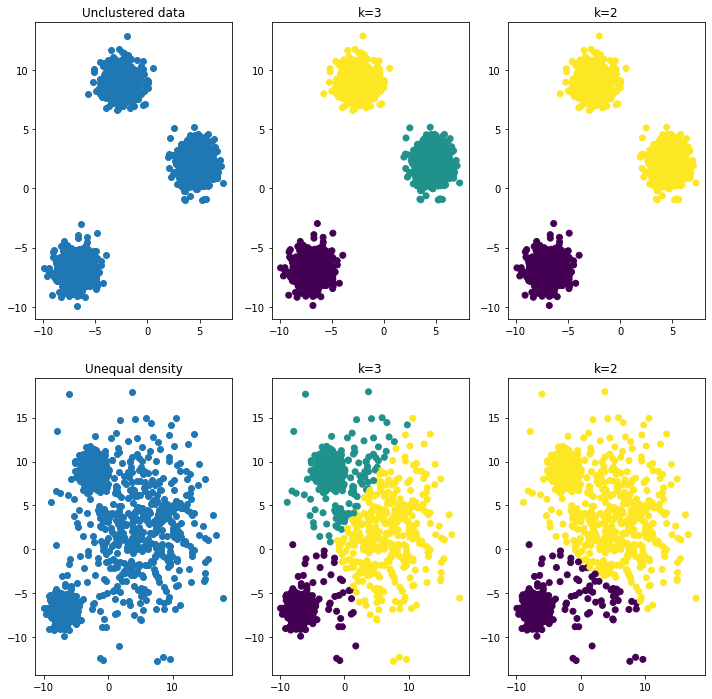

In [4]:
# k-Means on articial data
# Adapted from sklearn examples

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

# make artificial data (demo only, not part of the real-world process)
n_samples = 1500
random_state = 42
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Unlabeled data
plt.subplot(231)
plt.scatter(X[:, 0], X[:, 1])
plt.title("Unclustered data")

# Correct number of clusters
#  Note we are doing three steps (instantiate, fit, predict)
#  in one line of code here
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.subplot(232)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("k=3")


# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(233)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("k=2")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 5.0, 1.0],
                                random_state=random_state)

plt.subplot(234)
plt.scatter(X_varied[:, 0], X_varied[:, 1])
plt.title("Unequal density")

y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(235)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("k=3")

y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X_varied)

plt.subplot(236)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("k=2")


plt.show()

## Texts as high-dimensional data

As noted in the last problem set, we usually deal with far more than 2 dimensions of texts. If we use word counts as our features, it's easy to have 10,000 or 100,000 or more dimensions in our data set. We'll talk about this in a future lecture, but note for now that the problem of high-dimensional feature space is that **everything becomes far away from everything else**. This makes distance metrics and density measures less meaningful than they are in low-dimensional spaces.

One solution is **dimension reduction**, which ranges from the relatively simple (singular value decomposition, principal component analysis) to the very complex, indeed (vector embeddings from deep neural networks).